In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import numpy as np
import skquant.opt as skq

from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Qubit, Gate, Parameter, ParameterVector
from qiskit.tools.visualization import circuit_drawer 
from qiskit import Aer, execute
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.quantum_info import Operator, Pauli
from qiskit.opflow import PauliOp, SummedOp, ComposedOp
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn, AerPauliExpectation, MatrixExpectation
from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import BOBYQA, COBYLA, GradientDescent, SLSQP, SciPyOptimizer

from scipy.optimize import minimize

import itertools

In [2]:
##Specify backend for simulation
backend = Aer.get_backend('aer_simulator_statevector')

##Qubits on Lattice, Lattice Parameters
qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Nq = len(qubits)

xx_links = [(0, 3), (1, 2), (5, 9), (7, 8), (10, 13), (11, 12)]
yy_links = [(0, 1), (2, 3), (10, 11), (12, 13)]
yy_links_reversed = [(12, 13), (10, 11), (2, 3), (0, 1)]
zz_links = [(0, 4), (1, 6), (2, 5), (3, 7), (8, 10), (9, 11), (12, 14), (13, 15)]
zz_links_reversed = [(13, 15), (12, 14), (9, 11), (8, 10), (3, 7), (2, 5), (1, 6), (0, 4)]

Jx, Jy, Jz = -1.0/np.sqrt(2), -1.0/np.sqrt(2), -1.0
hX = hY = hZ = 0.05/np.sqrt(3)

In [3]:
##Hamiltonian Construction (Square-Octagon Model)

#Construct Pauli strings
XX_links_strings = []
for (i,j) in xx_links:
    XX_string = ""
    for q in range(Nq):
        if q != i and q != j:
            XX_string += 'I'
        else:
            XX_string += 'X'
    XX_links_strings.append(XX_string)
    
YY_links_strings = []
for (i,j) in yy_links:
    YY_string = ""
    for q in range(Nq):
        if q != i and q != j:
            YY_string += 'I'
        else:
            YY_string += 'Y'
    YY_links_strings.append(YY_string)

ZZ_links_strings = []
for (i,j) in zz_links:
    ZZ_string = ""
    for q in range(Nq):
        if q != i and q != j:
            ZZ_string += 'I'
        else:
            ZZ_string += 'Z'
    ZZ_links_strings.append(ZZ_string)

X_qubit_strings = []
Y_qubit_strings = []
Z_qubit_strings = []
for k in qubits:
    X_string = ""
    Y_string = ""
    Z_string = ""
    for q in range(Nq):
        if q != k:
            X_string += 'I'
            Y_string += 'I'
            Z_string += 'I'
        else:
            X_string += 'X'
            Y_string += 'Y'
            Z_string += 'Z'
    X_qubit_strings.append(X_string)
    Y_qubit_strings.append(Y_string)
    Z_qubit_strings.append(Z_string)

In [4]:
##Hamiltonian Construction (Square-Octagon Model) (ctd.)

#Construct individual terms of Hamiltonian as Nq-qubit Pauli Operators
XX_links_terms = []
YY_links_terms = []
ZZ_links_terms = []
for i in XX_links_strings:
    XX_links_terms.append(PauliOp(Pauli(i), coeff=float(Jx)))
for i in YY_links_strings:
    YY_links_terms.append(PauliOp(Pauli(i), coeff=float(Jy)))
for i in ZZ_links_strings:
    ZZ_links_terms.append(PauliOp(Pauli(i), coeff=float(Jz)))
    
X_qubit_terms = []
Y_qubit_terms = []
Z_qubit_terms = []
for i in X_qubit_strings:
    X_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hX)))
for i in Y_qubit_strings:
    Y_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hY)))
for i in Z_qubit_strings:
    Z_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hZ)))
    
#Construct Hamiltonian (for running with built-in VQE)
Hamiltonian = 0
for i in XX_links_terms:
    Hamiltonian += i
for i in YY_links_terms:
    Hamiltonian += i
for i in ZZ_links_terms:
    Hamiltonian += i
for i in X_qubit_terms:
    Hamiltonian += i
for i in Y_qubit_terms:
    Hamiltonian += i
for i in Z_qubit_terms:
    Hamiltonian += i

In [5]:
#Save Hamiltonian Details to text file
print(Hamiltonian, file=open("Hamiltonian_16_Qubit_Square_Octagon_Lattice_Details.txt", "a"))

In [6]:
##Exact Diagonalization of Hamiltonian (Square-Octagon Model)
GSEnergy = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=Hamiltonian)
print(GSEnergy)

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([ 4.62363736e-06-1.76735491e-06j,
             -1.09041199e-05-4.46315706e-06j,
             -1.09041199e-05-4.46315706e-06j, ...,
              8.14531227e-03-1.93396000e-02j,
              8.14531227e-03-1.93396000e-02j,
             -7.69156941e-01+3.11529137e-01j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': -9.700780655898777}


In [7]:
##Hamiltonian Variational Ansatz Circuit Construction
def HVA_circuit(n_layers):
    global xx_links
    global yy_links
    global zz_links
    global qubits
    #Declare variational parameters
    alpha_mag = ParameterVector(r'$\tilde{\alpha}$', n_layers)
    beta_mag = ParameterVector(r'$\tilde{\beta}$', n_layers)
    gamma_mag = ParameterVector(r'$\tilde{\gamma}$', n_layers)
    alpha = ParameterVector(r'$\alpha$', n_layers)
    beta = ParameterVector(r'$\beta$', n_layers)
    gamma = ParameterVector(r'$\gamma$', n_layers)
    #Initialize circuit
    HVA = QuantumCircuit(Nq)
    for idx_layer in range(n_layers):
    #Construct X-terms portion of layer
        for q in qubits:
            HVA.rx(2*alpha_mag[idx_layer], q)
        for (i,j) in xx_links:
            HVA.h(i)
            HVA.h(j)
            HVA.cx(max(i,j), min(i,j))
            HVA.rz(2*alpha[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
            HVA.h(i)
            HVA.h(j)
        HVA.barrier()
    #Construct Y-terms portion of layer
        for q in qubits:
            HVA.ry(2*beta_mag[idx_layer], q)
        for (i,j) in yy_links:
            HVA.rx(np.pi/2, i)
            HVA.rx(np.pi/2, j)
            HVA.cx(max(i,j), min(i,j))
        for (i,j) in yy_links_reversed:
            HVA.rz(2*beta[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
            HVA.rx(-np.pi/2,i)
            HVA.rx(-np.pi/2,j)
        HVA.barrier()
    #Construct Z-terms portion of layer
        for q in qubits:
            HVA.rz(2*gamma_mag[idx_layer], q)
        for (i,j) in zz_links:
            HVA.cx(max(i,j), min(i,j))
        for (i,j) in zz_links_reversed:
            HVA.rz(2*gamma[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
        HVA.barrier()
    return HVA

In [9]:
#Save HVA Circuit to text file (for sending to Wayne)
HVA = QuantumCircuit(Nq)
for idx_layer in range(1):
#Construct X-terms portion of layer
    for q in qubits:
        HVA.rx(2, q)
    for (i,j) in xx_links:
        HVA.h(i)
        HVA.h(j)
        HVA.cx(max(i,j), min(i,j))
        HVA.rz(2, min(i,j))
        HVA.cx(max(i,j), min(i,j))
        HVA.h(i)
        HVA.h(j)
        HVA.barrier()
#Construct Y-terms portion of layer
    for q in qubits:
        HVA.ry(2, q)
    for (i,j) in yy_links:
        HVA.rx(np.pi/2, i)
        HVA.rx(np.pi/2, j)
        HVA.cx(max(i,j), min(i,j))
    for (i,j) in yy_links_reversed:
        HVA.rz(2, min(i,j))
        HVA.cx(max(i,j), min(i,j))
        HVA.rx(-np.pi/2,i)
        HVA.rx(-np.pi/2,j)
        HVA.barrier()
#Construct Z-terms portion of layer
    for q in qubits:
        HVA.rz(2, q)
    for (i,j) in zz_links:
        HVA.cx(max(i,j), min(i,j))
    for (i,j) in zz_links_reversed:
        HVA.rz(2, min(i,j))
        HVA.cx(max(i,j), min(i,j))
        HVA.barrier()
HVA.qasm(True,"HVA_Circuit_1_Layer_16_Qubit_Square_Octagon.txt")

OPENQASM 2.0;
include "qelib1.inc";
qreg q[16];
rx(2) q[0];
rx(2) q[1];
rx(2) q[2];
rx(2) q[3];
rx(2) q[4];
rx(2) q[5];
rx(2) q[6];
rx(2) q[7];
rx(2) q[8];
rx(2) q[9];
rx(2) q[10];
rx(2) q[11];
rx(2) q[12];
rx(2) q[13];
rx(2) q[14];
rx(2) q[15];
h q[0];
h q[3];
cx q[3],q[0];
rz(2) q[0];
cx q[3],q[0];
h q[0];
h q[3];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15];
h q[1];
h q[2];
cx q[2],q[1];
rz(2) q[1];
cx q[2],q[1];
h q[1];
h q[2];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15];
h q[5];
h q[9];
cx q[9],q[5];
rz(2) q[5];
cx q[9],q[5];
h q[5];
h q[9];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15];
h q[7];
h q[8];
cx q[8],q[7];
rz(2) q[7];
cx q[8],q[7];
h q[7];
h q[8];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15];
h q[10];
h q[13];
cx q[13],q[10];
rz(2) q[10];
cx q[13],q[10];
h q[10];
h q[13];
barri

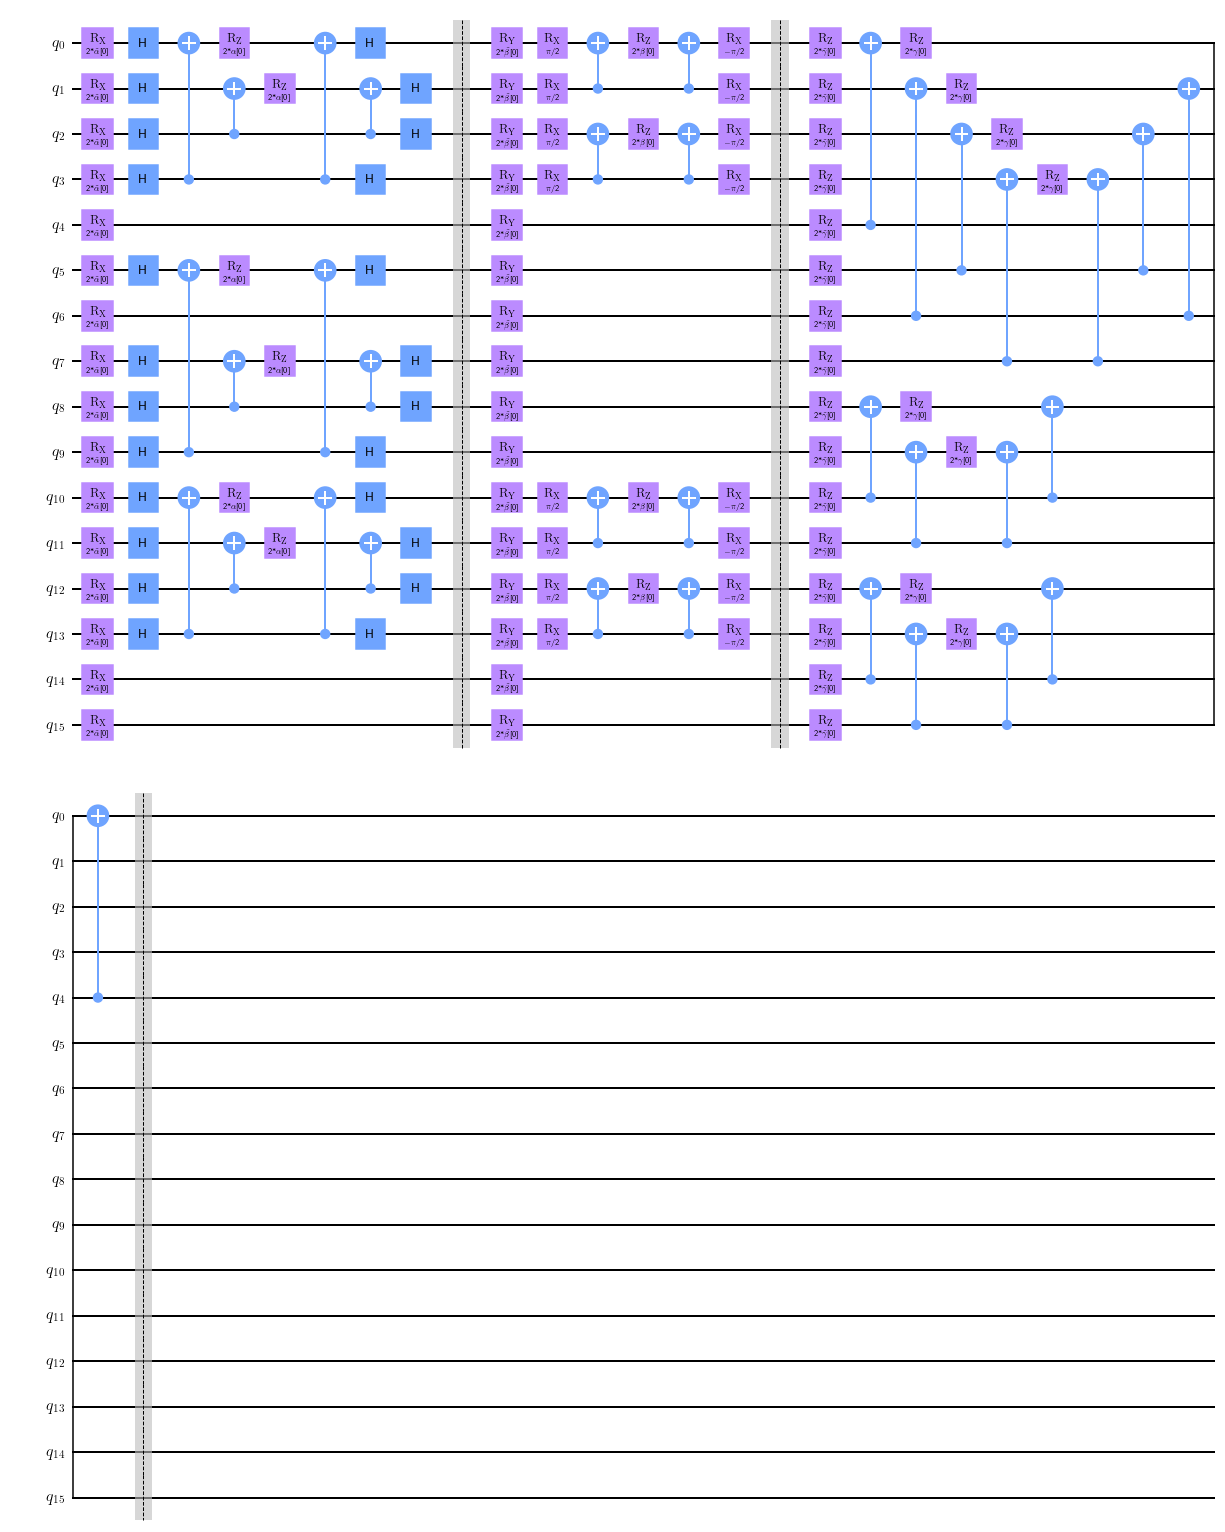

In [8]:
#Check HVA Circuit Layout
HVA_layout = HVA_circuit(1)
HVA_layout.draw('mpl', scale=None, filename='HVA_16_Qubit_Circuit_Diagram_Square_Octagon_Model')

In [10]:
##Perform VQE (Using Built-in VQE Algorithm in Qiskit)

#Maximum number of layers
n_layers_max = 4

#Specify classical optimizer
optimizer = COBYLA(maxiter=50000)

#Specify number of initial values
n_initial_vals_max = 501

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
np.random.seed(10) #Seed for reproducibility
    
##Execution
for n_layers in range(1,n_layers_max+1):
    for n_initial_vals in range(n_initial_vals_max):
        initial_point = np.random.uniform(0.0, 2*np.pi, size=HVA_circuit(n_layers).num_parameters)
        local_vqe = VQE(ansatz=HVA_circuit(n_layers),
                        optimizer=optimizer,
                        initial_point=initial_point,
                        quantum_instance=backend)

    local_result_1 = local_vqe.compute_minimum_eigenvalue(Hamiltonian)
    local_result_2 = local_vqe.get_optimal_circuit()
    print(local_result_1)
    print(local_result_2)

Note: Using a statevector_simulator with 16 qubits can be very expensive. Consider using the Aer qasm_simulator instead to take advantage of Aer's built-in fast Pauli Expectation


MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [9]:
#Construct ZZ Connected Correlation Functions for various distances
zz_correlation_links = [(4, 0), (4, 1), (4, 3), (4, 5), (4, 7), (4, 2), (4, 6)] 
z_single_terms = [4, 0, 1, 3, 5, 7, 2, 6]

ZZ_Correlation_links_strings = []
for (i,j) in zz_correlation_links:
    ZZ_Correlation_string = ""
    for q in range(Nq):
        if q != i and q != j:
            ZZ_Correlation_string += 'I'
        else:
            ZZ_Correlation_string += 'Z'
    ZZ_Correlation_links_strings.append(ZZ_Correlation_string)

Z_Single_Term_strings = []
for k in z_single_terms: 
    Z_string = ""
    for q in range(Nq):
        if q != k:
            Z_string += 'I'
        else:
            Z_string += 'Z'
    Z_Single_Term_strings.append(Z_string) 

ZZ_Correlation_links = []
for n in ZZ_Correlation_links_strings:
    ZZ_Correlation_links.append(PauliOp(Pauli(n)))
    
Z_Single_Terms = []
for n in Z_Single_Term_strings:
    Z_Single_Terms.append(PauliOp(Pauli(n)))

In [10]:
#Compute Expectation Values of the different Connected Correlation functions over different distances

Connected_Correlation_Function_Values = []
ZZ_Correlation_Function_Values = []
Z_Single_Term_Values = []
HVA_wfn = CircuitStateFn(local_result_2)

for n in range(len(ZZ_Correlation_links)):
    measurable_expression = StateFn(ZZ_Correlation_links[n], is_measurement=True).compose(HVA_wfn)
    expectation = MatrixExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend).convert(expectation)
    ZZ_Correlation_Function_Values.append(sampler.eval().real)

for n in range(len(Z_Single_Terms)):
    measurable_expression = StateFn(Z_Single_Terms[n], is_measurement=True).compose(HVA_wfn)
    expectation = MatrixExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend).convert(expectation)
    Z_Single_Term_Values.append(sampler.eval().real)
    
for r in range(len(ZZ_Correlation_links)):
    Connected_Correlation_Function_Values.append(ZZ_Correlation_Function_Values[r]-Z_Single_Term_Values[0]*Z_Single_Term_Values[r+1])

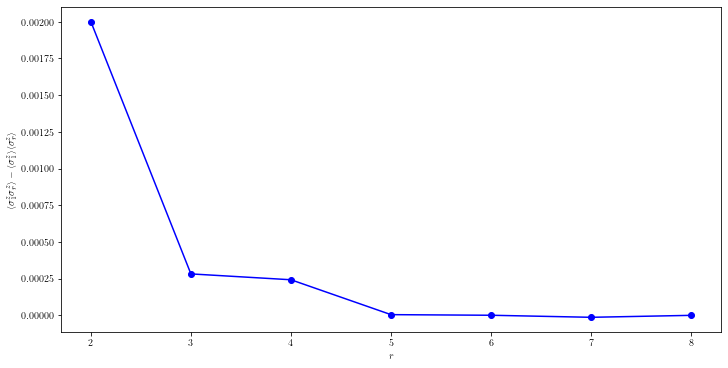

In [11]:
#Plot Connected Correlation Function vs. Distance

plt.figure(figsize=(10, 5), layout='constrained')
plt.plot([2, 3, 4, 5, 6, 7, 8], Connected_Correlation_Function_Values, color = 'blue', marker = 'o')
plt.xlabel(r"$r$")
plt.ylabel(r"$\langle\sigma_{1}^{z}\sigma_{r}^{z}\rangle-\langle\sigma_{1}^{z}\rangle\langle\sigma_{r}^{z}\rangle$")
plt.show()